In [ ]:
from fastquant import get_stock_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
# Data Prep - Helper Methods/Vars

train_range = 60 # length of days to split data on
high_dimensions = 1
fractional_dimensions = 3

# Extract factional change, fractional high, and fractional low
# No normalization/standardization
def frac_data_prep(data):
    df = pd.DataFrame(data=None, columns=['fracChange','fracHigh','fracLow'])
    df['fracChange'] = (data['close']-data['open'])/data['open']
    df['fracHigh'] = (data['high']-data['open'])/data['open']
    df['fracLow'] = (data['open']-data['low'])/data['open']

    return df

# Extract high
# Normalize high Data
def high_data_prep(train_data, test_data, scaler):
    # df_train = pd.DataFrame(data=None, columns=['high'])
    # df_train['high'] = train_data['high']
    high_train_data = train_data['high'].values

    # df_test = pd.DataFrame(data=None, columns=['high'])
    # df_test['high'] = test_data['high']
    high_test_data = test_data['high'].values

    high_train_data = high_train_data.reshape(-1,1)
    high_test_data = high_test_data.reshape(-1,1)

    train_scale = scaler.fit_transform(high_train_data)
    test_scale = scaler.transform(high_test_data)

    return train_scale, test_scale, high_test_data, scaler

# Split train/test data into x/y sets
def get_x_y_sets(train_data, test_data, dimensions):
    X_train = []
    Y_train = []
    for i in range(train_range, len(train_data)):
        X_train.append(train_data[i-train_range:i,0])
        Y_train.append(train_data[i,0])

    x_train, y_train = np.array(X_train), np.array(Y_train)

    x_train = np.reshape(x_train, (*x_train.shape, dimensions))

    X_test = []
    for i in range(train_range, len(test_data)):
        X_test.append(train_data[i-train_range:i,0])
    
    x_test = np.array(X_test)

    x_test = np.reshape(x_test, (*x_test.shape, dimensions))

    return x_train, y_train, x_test


In [ ]:
# Plotting methods
def plot_results(preds, actual, title):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(title)
    time = range(len(preds))
    ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
    ax.plot(time,actual,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
    ax.set_xlabel('time')
    ax.set_ylabel('stock price ($)')
    ax.set_xticks(np.arange(0,len(preds)+10,10))
    ax.set_xlim(0,len(preds)+10)
    ax.xaxis.grid(True,ls='--')
    ax.yaxis.grid(True,ls='--')
    ax.legend()
    fig.tight_layout()
    plt.savefig(f'../imgs/{title}.png', ext='png', bbox_inches="tight")  

In [ ]:
# Data Prep - Get Data
# training with apple feb-10-2003 -> sep-10-2004
full_apple_train = get_stock_data("AAPL","2003-02-10","2004-09-10")
# testing with apple sep-13-2004 -> jan-21-2005
full_apple_test =  get_stock_data("AAPL","2004-09-13","2005-01-21")
# training with IBM feb-10-2003 -> sep-10-2004
full_ibm_train = get_stock_data("IBM","2003-02-10","2004-09-10")
# testing with IBM sep-13-2004 -> jan-21-2005
full_ibm_test =  get_stock_data("IBM","2004-09-13","2005-01-21")

# Not available...
# training with dell feb-10-2003 -> sep-10-2004
# full_dell_train = get_stock_data("dell","2003-02-10","2004-09-10")
# testing with dell sep-13-2004 -> jan-21-2005
# full_dell_test =  get_stock_data("dell","2004-09-13","2005-01-21")

In [ ]:
# Data Prep - Build Train/Test Sets

# Prepare Fractional Change/High/Low Data
frac_apple_train = frac_data_prep(full_apple_train)
frac_apple_test = frac_data_prep(full_apple_test)
frac_ibm_train = frac_data_prep(full_ibm_train)
frac_ibm_test = frac_data_prep(full_ibm_test)

# Prepare High Data
# high_apple_train, high_apple_test = high_data_prep(full_apple_train, full_apple_test)
# high_ibm_train, high_ibm_test = high_data_prep(full_ibm_train, full_ibm_test)

In [ ]:
# Build SimpleRNN Model
# 3 SimpleRNN layers with 32 inputs. Returns full sequence.
# 1 SimpleRNN layer with 32 inputs. Does not return full sequence
# 1 Dense layer with 1 input. 
# input -> 32 -> 32 -> 32 -> 32noFS -> 1
# Activation: Tanh
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
sr_optimizer = 'rmsprop'
sr_loss = 'mean_absolute_percentage_error'
# sr_loss = 'mean_squared_error'
sr_epochs = 100
sr_batch_size = 150

# Builds a new instance of Simple RNN and scaler (if needed)
def build_simple_rnn():
    scaler = MinMaxScaler(feature_range=(0,1))

    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer=sr_optimizer, loss=sr_loss)

    return model, scaler

In [ ]:
# Train/Predict method
def train_predict_high(full_train_data, full_test_data, model, scaler, in_epochs, in_batch_size):
    scaled_train, scaled_test, raw_test, scaler = high_data_prep(full_train_data, full_test_data, scaler)

    x_train, y_train, x_test = get_x_y_sets(scaled_train, scaled_test, high_dimensions)

    model.fit(x_train, y_train, epochs=in_epochs, batch_size=in_batch_size)

    scaled_predictions = model.predict(x_test)
    test_predictions = scaler.inverse_transform(scaled_predictions)

    return model, test_predictions, raw_test

In [ ]:
simple_rnn_apple, sr_scaler_apple = build_simple_rnn()
simple_rnn_apple, y_preds, test_data = train_predict_high(full_apple_train, full_apple_test, simple_rnn_apple, sr_scaler_apple, sr_epochs, sr_batch_size)
diff = len(test_data) - len(y_preds)
plot_results(y_preds, test_data[diff:], 'Simple RNN MAPE - Apple using High')

simple_rnn_ibm, sr_scaler_ibm = build_simple_rnn()
simple_rnn_ibm, y_preds, test_data  = train_predict_high(full_ibm_train, full_ibm_test, simple_rnn_ibm, sr_scaler_ibm, sr_epochs, sr_batch_size)
diff = len(test_data) - len(y_preds)
plot_results(y_preds, test_data[diff:], 'Simple RNN MAPE - IBM using High')

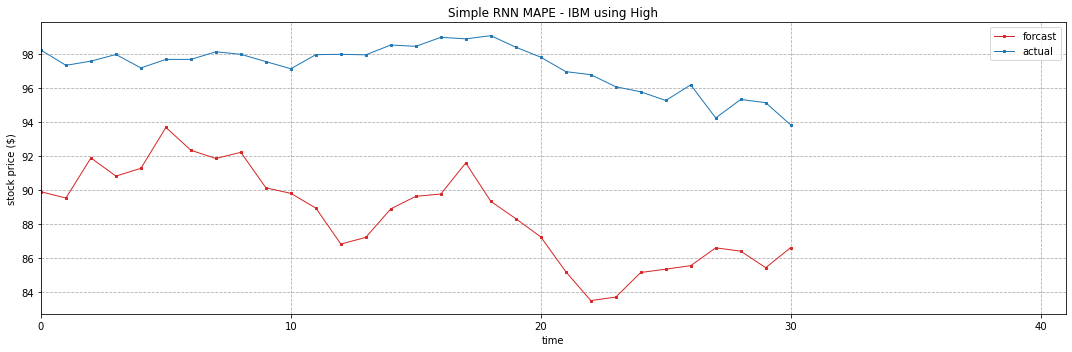

In [29]:
# plot_results(y_preds, test_data[diff:], 'Simple RNN MAPE - IBM using High')